# Graded Assignment 2 - Air Quality and Weather in the Netherlands


# Introduction to This Template Notebook

* This is a **group** notebook.
* Make sure you work in a **copy** of `...-template.ipynb`,
**renamed** to `...-yourIDnrs.ipynb`,
where `yourIDnrs` is the TU/e identification numbers of the members of the group.

<div class="alert alert-danger" role="danger">
<h3>Integrity</h3>
<ul>
    <li>In this course you must act according to the rules of the TU/e code of scientific conduct.</li>
    <li>This exercise or graded assignment is to be executed by the members of the group independently from other people.</li>
    <li>You must not copy from the Internet, your friends, books... If you represent other people's work as your own, then that constitutes fraud and will be reported to the Examination Committee.</li>
    <li>Making your work available to others (complicity) also constitutes fraud.</li>
</ul>
</div>

You are expected to work with Python code and Markdown in this notebook.

Proceed in this notebook as follows:
* **Read** the assignment (separate PDF).
* **Write** your decisions/solutions/interpretations in the appropriate sections.
  * For this you can use both Code and Markdown cells. Information about how to use these cells is available in the _Getting Started_ assignment.
* **Run** _all_ code cells (also the ones _without_ your code),
    _in linear order_ from the first code cell.

**Personalize your notebook**:
1. Copy the following line of code:

  ```python
  AUTHOR_ID_NRS = ['1234567', '2234567', '3234567', '4234567']
  ```
1. Paste them between the marker lines in the next code cell.
1. Fill in the _identification numbers_ of all members of the group as a list of strings between the `Author` markers.
1. Run the code cell by putting the cursor there and typing **Control-Enter**.


In [1]:
#// BEGIN_TODO [Author] Name, Id.nr., Date, as strings (1 point)

AUTHOR_ID_NRS = ['2047810', '2234567', '3234567', '4234567', '1998633']

#// END_TODO [Author]

## Table of Contents

- [Preparation](#Preparation)
    - [Load the libraries](#Load-the-libraries)
- [Part 1a. Hypothesis selection](#Part-1a:-Hypothesis-selection)
- [Part 1b. Hypothesis refinement](#Part-1b:-Hypothesis-refinement)
- [Part 2. Queries and data cleaning](#Part-2:-Queries-and-data-cleaning)
- [Part 3. Hypothesis testing and interpretation](#Part-3.-Hypothesis-testing-and-interpretation)
- [Part 4. Pitching results](#Part-4.-Pitching-results)

## Preparation
### Load the libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression         # for linear regression
from sklearn.cluster import KMeans                        # for clustering
from sklearn.tree import DecisionTreeClassifier           # for decision tree mining
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
from treeviz import tree_print                            # to print decision tree

import scipy.stats as stats                               # to compute z-scores
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import sqlite3                                            # to interact with the database
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline                                 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                                     # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5                    # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1                 # to fix issue with seaborn box plots; needed after import seaborn

## Part 1a: Hypothesis selection

Our three hyptheses are:

- 1: O3 levels rise due to weather factors that increase in the summer (humidity, temperature, sunlight duration).

- 2: pm_10 levels are affected by rainfall, windspeed, and temperature.

- 3: ???

## Part 1b: Hypothesis refinement

Original: O3 levels rise due to weather factors that increase in the summer ( Humidity / Temperature / Sun Duration)
    
Refined: O3 Levels rise in the summer due to an increase in humidity and temperature.

Proposition of hypothesis: 
We looked at the posters from GA1 and exchanged our respective conclusions. From this we discovered the possibility that O3 is affected by humidity and temperature, and wrote down our original hypothesis.

We removed precipitation, because the data is hard to work with and it can be tedious to find good connections. Then we also removed sun duration from the hypothesis, because having four different factors to look into is going to be too complicated for the time span we are given for this assignment.

After that, we tried to pick an Air Quality and a Weather station that is located further inland to decrease the effect of the sea on the climate as much as possible (The sea warms the air in the winter and cools the air in the summer which will result in less difference in temperature, The sea also causes more rain in general which will also decrease less difference in humidity).

We chose this specific weather station, because it not in, or close to, a big city so that our data is minimally impacted by the pollution of urban areas. The weather station does not need to be really close to the measuring station, temperature and humidity will have minimal fluctuation over a distance of 10-20km.

## Part 2: Queries and data cleaning

In [20]:
# (Julian Luijke)
# Path and connect to the database in the files (doesnt need to be repeated in code again)
cnx = sqlite3.connect("datasets/aqw.db")

# Name all the weather factors needed (doesnt need to be repeated in code again), remove some of these if it is one that's not needed
WEATHER_FACTORS = ['wind_direction', 'wind_speed', 'wind_gust', 'temperature', 
                  'sunshine_duration', 'global_radiation', 'precipitation', 
                  'air_pressure', 'visibility', 'cloud_cover', 'humidity', 
                  'fog', 'rainfall', 'snow', 'thunder', 'ice_formation']

# Get all the info for the dataframe of the air quality station using the code
# The dataframe for the one near the sea
QUERY_AQ_SEA = f"""
    SELECT datetime, {', '.join(("o_3", "pm_10"))} 
    FROM air_quality_data 
    WHERE station_code='{"NL10319"}'
"""

# The dataframe for the one more landinward
QUERY_AQ_LAND = f"""
    SELECT datetime, {', '.join(("o_3", "pm_10"))} 
    FROM air_quality_data 
    WHERE station_code='{"NL10821"}'
"""
# Get O3 and pm_10 info of the air quality station in a dataframe
# Sea one
df_aq_sea = pd.read_sql_query(QUERY_AQ_SEA, cnx, index_col='datetime', parse_dates=['datetime'])

# Land one
df_aq_land = pd.read_sql_query(QUERY_AQ_LAND, cnx, index_col='datetime', parse_dates=['datetime'])

# Get all the info about the weather factor ready to put in a dataframe using the code of the chosen weather station
QUERY_WEATHER_SEA = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={"310"}
"""

QUERY_WEATHER_LAND = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={"290"}
"""

# Get weather data of the weather station chosen in a dataframe
df_weather_sea = pd.read_sql_query(QUERY_WEATHER_SEA, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])

df_weather_land = pd.read_sql_query(QUERY_WEATHER_LAND, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])

# Close database connection
cnx.close()

# Make both dataframes (of the weather and compound levels of each station + close weather station) be in the same one
df_data_sea = df_aq_sea.join(df_weather_sea, how='outer')
df_data_land = df_aq_land.join(df_weather_land, how='outer')

# To show either one of the dataframes in case needed: remove the # from either one of them
#df_data_sea
#df_data_land

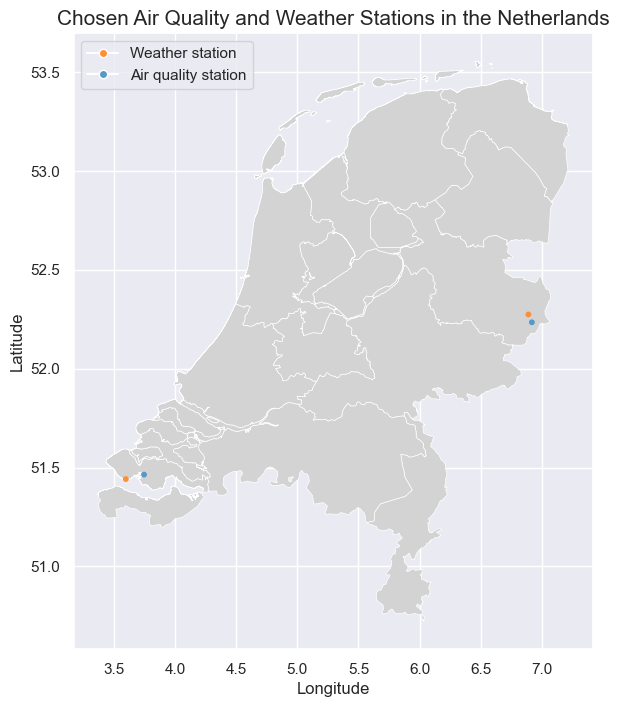

In [19]:
def plot_stations_on_map(df_stations):
    map_nl = gpd.read_file('./datasets/stanford-st293bj4601-shapefile.zip')

    gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(df_stations['longitude'], df_stations['latitude'])])
    gdf['color'] = list(df_stations['color'])
    gdf.crs = map_nl.crs

    f, ax = plt.subplots(1, figsize=(8, 8))

    map_nl.plot(linewidth=0.5, edgecolor='white', color='lightgrey',legend=True, ax=ax)
    gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=10)

    ax.set_title('Chosen Air Quality and Weather Stations in the Netherlands', size=15)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    legend = [
        Line2D([0], [0], markerfacecolor='#FF8F35', marker='o', color='w', label='Weather station'),
        Line2D([0], [0], markerfacecolor='#5499C7', marker='o', color='w', label='Air quality station')
    ]
    ax.legend(handles=legend, loc='upper left')
    return ax
    
def all_stations():
    aqs_sql = "SELECT name, latitude, longitude FROM air_quality_stations WHERE name = 'Nieuwdorp-Coudorp' OR name = 'Enschede-Winkelhorst.'"
    ws_sql = "SELECT name, latitude, longitude FROM weather_stations WHERE name = 'Vlissingen' OR name = 'Twenthe'"
    with sqlite3.connect('./datasets/aqw.db') as conn:
        df_aqs = pd.read_sql_query(aqs_sql, conn)
        df_ws = pd.read_sql_query(ws_sql, conn)
    df_aqs['color'] = "#5499c7"
    df_ws['color'] = "#ff8f35"
    return pd.concat([df_ws, df_aqs])

plot_stations_on_map(all_stations());

## Part 3. Hypothesis testing and interpretation

In [ ]:
# Use this cell as you like, and add more cells as needed.

## Part 4. Polishing and pitching results

In [ ]:
# This section is only for generating figures if you need it. You may leave it empty.

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these exercises?

Assign a number to `feedback_time`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 point)

#// END_FEEDBACK [Feedback_1] (0 point)

import numbers

assert isinstance(feedback_time, numbers.Number), "Please assign a number to feedback_time"
print(feedback_time)

### How difficult did you find these exercises?

Assign an integer to `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 point)

#// END_FEEDBACK [Feedback_2] (0 point)

import numbers

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to feedback_difficulty"
print(feedback_difficulty)

### (Optional) What did you like?

Assign a string to `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_3] (0 point)

#// END_FEEDBACK [Feedback_3] (0 point)

### (Optional) What can be improved?

Assign a string to `feedback_improve`. Please be specific, so that we can act on your feedback. For example, mention the specific exercises and what was unclear.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_4] (0 point)

#// END_FEEDBACK [Feedback_4] (0 point)




## How to Submit Your Work

1. **Before submitting**, you must run your notebook by doing **Kernel > Restart & Run All**.  
   Make sure that your notebook runs without errors **in linear order**.
1. Remember to rename the notebook as explained at the beginning of this notebook.
1. Submit the executed notebook with your work
   for the appropriate assignment in **Canvas**.
1. In the **Momotor** tab in Canvas,
  you can select that assignment again to find some feedback on your submitted work.
  If there are any problems reported by _Momotor_,
  then you need to fix those,
  and **resubmit the fixed notebook**.

In case of a high workload on our server
(because many students submit close to the deadline),
it may take longer to receive the feedback.




---

In [ ]:
# List all defined names
%whos

---

# (End of Notebook) <span class="tocSkip"></span>

&copy; 2017-2023 - **TU/e** - Eindhoven University of Technology